In [143]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding,get_scheduler
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# Import the custom rules-based utilities
from rules import preprocess_texts, custom_loss, augment_features
from transformers import RobertaForSequenceClassification
import torch.nn as nn


In [260]:
class CustomQuBERTaClassifier(nn.Module):
    def __init__(self, model_name, num_labels, feature_dim):
        super(CustomQuBERTaClassifier, self).__init__()
        # Load the pre-trained QuBERTa model from Llamacha
        self.quberta = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        
        # Additional layers for handling features
        self.feature_layer = nn.Linear(feature_dim, feature_dim)
        self.dropout = nn.Dropout(0.1)
        # Adjust the classifier to take concatenated feature vector and last hidden state
        self.classifier = nn.Linear(self.quberta.config.hidden_size + feature_dim, num_labels)
        
    def forward(self, input_ids, attention_mask, features):
        # Pass input through QuBERTa model
        outputs = self.quberta.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:, 0, :]  # Take the output from the [CLS] token

        # Process features
        feature_output = self.feature_layer(features)
        feature_output = self.dropout(feature_output)

        # Concatenate pooled output and feature output
        combined_output = torch.cat((sequence_output, feature_output), dim=1)
        logits = self.classifier(self.dropout(combined_output))

        return logits

# Example of initialization and forward pass
model = CustomQuBERTaClassifier('Llamacha/QuBERTa', num_labels=22, feature_dim=1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [195]:
class CustomRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # You can add more layers if you need, for example:
        self.features_layer = nn.Linear(1, config.hidden_size)  # Assuming 'features' is a single scalar feature
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size + config.hidden_size, config.num_labels)  # Adjust input features accordingly

    def forward(self, input_ids=None, attention_mask=None, features=None, labels=None):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[1]  # The pooled output is typically at index 1
        
        features_output = self.features_layer(features.unsqueeze(-1))  # Ensure features is the right shape
        features_output = self.dropout(features_output)
        
        # Concatenate pooled output and features output
        concatenated_output = torch.cat((sequence_output, features_output), dim=-1)
        
        logits = self.classifier(concatenated_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs
    

    


In [247]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=22)  # adjust num_labels as necessary
# Assuming your model is initialized correctly with the required configuration
# model = CustomRobertaForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=22)
# model = CustomQuBERTaModel("Llamacha/QuBERTa", num_labels=22, num_features=1)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [248]:
def split_document(text, max_length=512, overlap=50):
    tokens = tokenizer.tokenize(text)
    parts = []
    if len(tokens) <= max_length:
        return [tokens]
    i = 0
    while i < len(tokens):
        parts.append(tokenizer.convert_tokens_to_ids(tokens[i:i+max_length]))
        i += (max_length - overlap)
    return parts


In [180]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [246]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read().strip()
                text = remove_numbers(text)

                # Preprocess text with rules and augment features
                text = preprocess_texts([text])[0]
                features_dict = augment_features([text], label_dict)[0]

                # Tokenize text and include attention mask
                encoded_text = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
                input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                
                # Append the rule-based features to the model input
                processed_data.append({
                    'input_ids': input_ids_list,
                    'attention_mask': attention_mask_list,
                    'labels': label_dict[dialect],
                    'features': features_dict  # Ensure this is always added
                })
    return processed_data


In [262]:
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_masks = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    features = torch.stack([item['features'] for item in batch])  # Stack features

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels,
        'features': features  # Pass the features tensor
    }


In [245]:
# class CustomTrainer(Trainer):
#     def __init__(self, *args, label_dict, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.label_dict = label_dict

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in inputs['input_ids']]
#         loss = custom_loss(logits, labels, texts, self.label_dict, alpha=0.5)  # Pass label_dict to custom_loss
#         return (loss, outputs) if return_outputs else loss

class CustomTrainer(Trainer):
    def __init__(self, *args, label_dict, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_dict = label_dict

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Pop the features before passing inputs to the model
        features = inputs.pop("features", None)
        outputs = model(**inputs)
        logits = outputs.logits
        texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in inputs['input_ids']]
        
        # Now you need to decide how to use `features` in your loss calculation
        # For now, we assume `custom_loss` can handle these features
        # Update custom_loss if it does not already handle additional feature inputs
        loss = custom_loss(logits, labels, texts, self.label_dict, features, alpha=0.5)  # Pass label_dict and features to custom_loss
        return (loss, outputs) if return_outputs else loss


In [198]:
# Define your directory paths correctly
directory_paths = {
    # 'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'qub': '../language_resources/dialects_mixed_txt/qub',
    'quf': '../language_resources/dialects_mixed_txt/quf',
    'quh': '../language_resources/dialects_mixed_txt/quh',
    'quk': '../language_resources/dialects_mixed_txt/quk',
    'qul': '../language_resources/dialects_mixed_txt/qul',
    'qup': '../language_resources/dialects_mixed_txt/qup',
    'quw': '../language_resources/dialects_mixed_txt/quw',
    'qux': '../language_resources/dialects_mixed_txt/qux',
    'quy': '../language_resources/dialects_mixed_txt/quy',
    'quz': '../language_resources/dialects_mixed_txt/quz', 
    'qvc': '../language_resources/dialects_mixed_txt/qvc',
    'qve': '../language_resources/dialects_mixed_txt/qve',  
    'qvi': '../language_resources/dialects_mixed_txt/qvi',
    'qvm': '../language_resources/dialects_mixed_txt/qvm',
    'qvn': '../language_resources/dialects_mixed_txt/qvn',
    'qvo': '../language_resources/dialects_mixed_txt/qvo',
    'qvw': '../language_resources/dialects_mixed_txt/qvw',
    'qwh': '../language_resources/dialects_mixed_txt/qwh',
    'qxl': '../language_resources/dialects_mixed_txt/qxl',
    'qxn': '../language_resources/dialects_mixed_txt/qxn',
    'qxo': '../language_resources/dialects_mixed_txt/qxo',
    'qxr': '../language_resources/dialects_mixed_txt/qxr',
    # 'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}


In [261]:
# go through loading & processing
processed_data = load_and_preprocess(directory_paths)

In [263]:
# Quick check to see if any key is missing in any data item
for data in processed_data:
    if not all(key in data for key in ['input_ids', 'attention_mask', 'labels', 'features']):
        print("Data item missing keys:", data)

In [264]:
print(processed_data)

for item in processed_data[:5]:  # Print the first five items to check their structure
    print(item)

[{'input_ids': [0, 193, 193, 193, 194, 38, 1842, 193, 193, 209, 193, 193, 193, 201, 193, 193, 193, 209, 193, 193, 193, 197, 203, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 201, 193, 193, 193, 201, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 195, 193, 193, 193, 193, 193, 193, 193, 207, 193, 193, 193, 194, 193, 193, 209, 193, 193, 77, 193, 82, 193, 69, 193, 80, 45, 724, 71, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 19

In [265]:
# Create the dataset directly from a dictionary
dataset = Dataset.from_dict({
    'input_ids': [x['input_ids'] for x in processed_data],
    'attention_mask': [x['attention_mask'] for x in processed_data],
    'labels': [x['labels'] for x in processed_data],
    'features': [x['features'] for x in processed_data]  # Ensure this is present
})

# Set dataset format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'features'])


In [278]:
print(dataset["features"])

TypeError: list indices must be integers or slices, not str

In [267]:
print(dataset[0])  # Print the first item in the dataset

{'input_ids': tensor([   0,  193,  193,  193,  194,   38, 1842,  193,  193,  209,  193,  193,
         193,  201,  193,  193,  193,  209,  193,  193,  193,  197,  203,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  201,  193,  193,
         193,  201,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  195,  193,
         193,  193,  193,  193,  193,  193,  207,  193,  193,  193,  194,  193,
         193,  209,  193,  193,   77,  193,   82,  193,   69,  193,   80,   45,
         724,   71,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,  193,
         193,  193,  193, 

In [268]:
# Split the dataset
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

In [269]:
# train_sampler = RandomSampler(train_dataset)
# train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)


In [270]:
# List to store accuracy per epoch
epoch_accuracy = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [273]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=20,
#     per_device_train_batch_size=10,
#     per_device_eval_batch_size=15,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy="epoch"
# )

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,  # Increased epochs
    per_device_train_batch_size=16,  # Slightly larger batch size
    per_device_eval_batch_size=64,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy"
)


label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}

# Set up the custom Trainer with the new dataset
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    label_dict=label_dict  # Pass the label dictionary
)


In [276]:
import torch

model.train()  # Set the model to training mode (this enables dropout, batchnorm, etc.)

for epoch in range(num_epochs):  # `num_epochs` is the number of epochs you plan to train
    for batch in dataloader:  # `dataloader` iterates over batches of the dataset
        # Move batch to the same device as model (e.g., GPU if available)
        batch = {k: v.to(device) for k, v in batch.items()}  # 'device' could be 'cuda' or 'cpu'
        
        outputs = model(**batch)  # Pass the batch through the model
        loss = outputs.loss  # Assume the model returns a loss in its output

        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients of all variables wrt loss
        optimizer.step()  # Update all parameters based on gradients

        print(f"Epoch {epoch}, Loss: {loss.item()}")  # Optionally print the loss


NameError: name 'dataloader' is not defined

In [272]:
trainer.train()

  0%|          | 0/300 [00:00<?, ?it/s]

KeyError: 'labels'

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


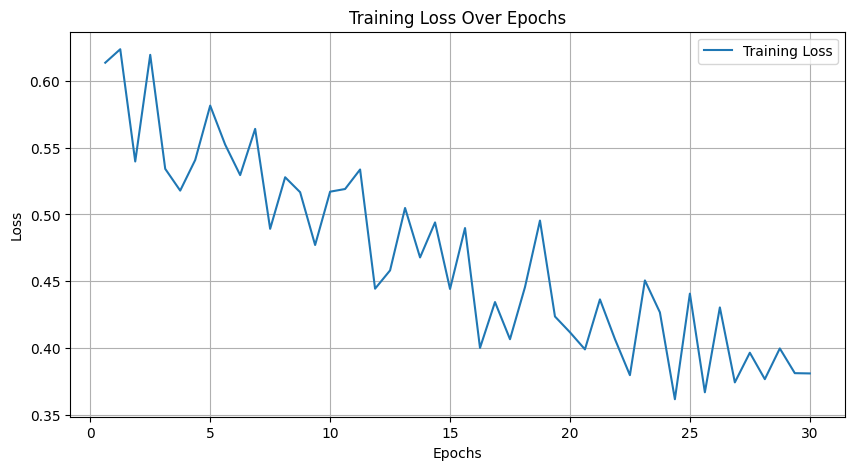

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


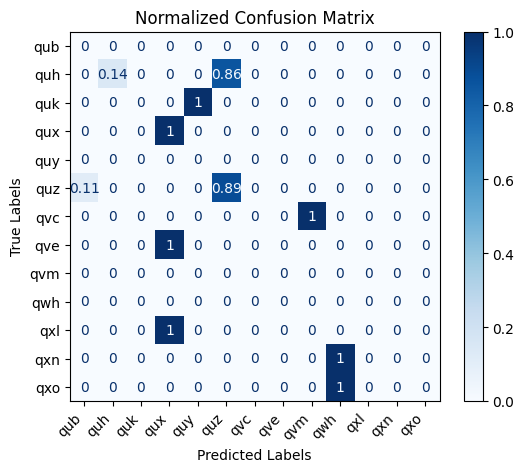

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(trainer):
    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    preds_flat = predictions.argmax(-1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds_flat, normalize='true')

    # Extract unique labels (sorted by value) to ensure consistent label names
    unique_labels = np.unique(np.concatenate((labels, preds_flat)))
    label_names = [list(directory_paths.keys())[label] for label in unique_labels]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45, ha="right")  # Optional: Rotate labels for better visibility
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(trainer)



  0%|          | 0/2 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metric

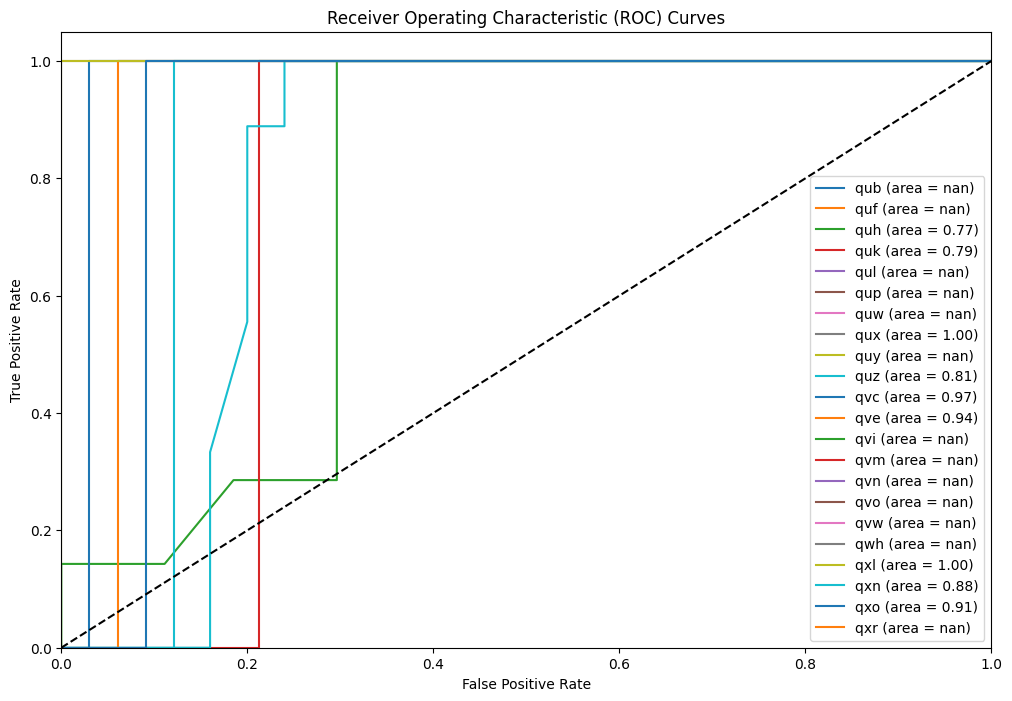

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curves(trainer):
    # Get predictions and labels
    predictions, labels, _ = trainer.predict(val_dataset)
    predictions_softmax = torch.nn.functional.softmax(torch.from_numpy(predictions), dim=1).numpy()
    
    # Binarize the labels for each class
    labels_bin = label_binarize(labels, classes=np.arange(len(directory_paths)))
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(directory_paths)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], predictions_softmax[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{list(directory_paths.keys())[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(trainer)


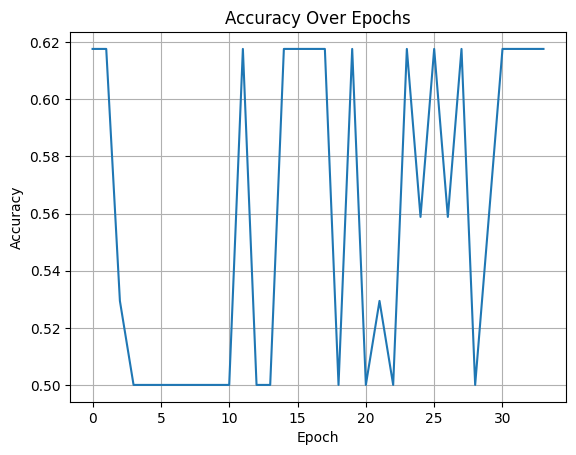

In [51]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

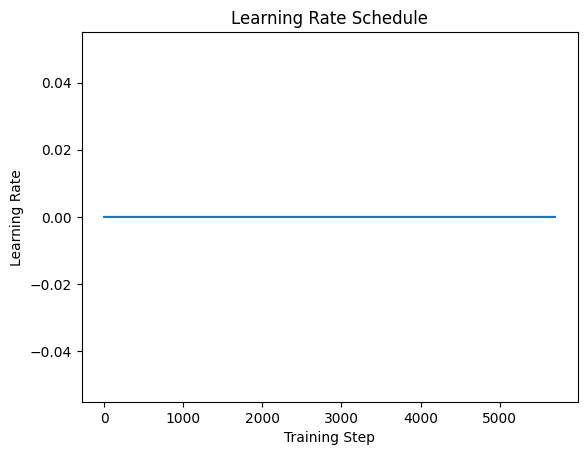

In [52]:
scheduler = get_scheduler(
    name="cosine", 
    optimizer=trainer.optimizer, 
    num_warmup_steps=800, 
    num_training_steps=len(train_dataset) * training_args.num_train_epochs
)

lrs = [scheduler.get_lr()[0] for _ in range(len(train_dataset) * training_args.num_train_epochs)]
plt.plot(lrs)
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()